<font size="4"><font color='Blue'>**Import Libraries**</font>

In [49]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from mlxtend.plotting import plot_decision_regions, plot_confusion_matrix

<font size="4"><font color='Blue'>**Import Datasets**</font>

In [50]:
#Import the conversion traning and clicklog datasets
training_df = pd.read_csv ('Training Data.csv')
clicklog_df = pd.read_csv ('click_log.csv')

C:\Users\adhit\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (22,24,25,26,29,30,31,32,33,34,46,47,48,49,50,51,52,53,54) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<font size="4"><font color='Blue'>**Merge Conversion Training and Click log datasets**</font>

In [51]:
clicklog_train = pd.merge(training_df, clicklog_df, left_on=['imprid_cr'], right_on = ['imprId'], how = 'inner')

<font size="4"><font color='Blue'>**Data Preprocessing & Feature Engineering**</font>

In [52]:
# Identify essesntial fields required for modelling
essential_train = ['clientid_cr', 'clmbuserid_cr', 'imprid_cr', 'pubclientid_cr','clickIp', 'siteId_cr', 'goalid_cr', 
               'cityId_cr', 'stateId_cr', 'countryDimId_cr', 'browserId_cr', 'adslotdimid_cr', 'ispDimId_cr', 
                  'devTypeDimId', 'osVerDimId_cr', 'conversion_fraud']

clicklog_train = clicklog_train[essential_train]

In [53]:
# Remove NULL values
clicklog_train['devTypeDimId'] = clicklog_train['devTypeDimId'].fillna (0.0)
clicklog_train['clickIp'] = clicklog_train['clickIp'].astype('str')

In [54]:
# Label encoding of categorical columns
label_encoder = LabelEncoder()
#,'imprid_cr','clickIp'
for cols in ['clmbuserid_cr', 'imprid_cr', 'clickIp', 'conversion_fraud']:    
    # Encode labels in column 'species'.
    clicklog_train[cols]= label_encoder.fit_transform(clicklog_train[cols])  

In [55]:
#Normalize the data before modelling
min_max_scaler = MinMaxScaler()
# apply normalization techniques
columns = ['clientid_cr', 'clmbuserid_cr', 'imprid_cr', 'pubclientid_cr','clickIp', 'siteId_cr', 'goalid_cr', 
               'cityId_cr', 'stateId_cr', 'countryDimId_cr', 'browserId_cr', 'adslotdimid_cr', 'ispDimId_cr', 
                  'devTypeDimId', 'osVerDimId_cr']
for col in columns:
    clicklog_train[col] = MinMaxScaler().fit_transform(np.array(clicklog_train[col]).reshape(-1,1))

In [56]:
# Identify the features and label
y = clicklog_train['conversion_fraud']
X = clicklog_train.drop(['conversion_fraud'], axis=1)

In [57]:
# Prepare the Conversion test data similar to Training data
test_df = pd.read_csv ('Test Data.csv')
clicklog_test = pd.merge(test_df, clicklog_df, left_on=['imprid_cr'], right_on = ['imprId'], how = 'left')
essential_test = ['record_id', 'clientid_cr', 'clmbuserid_cr', 'imprid_cr', 'pubclientid_cr','clickIp', 'siteId_cr', 'goalid_cr', 
               'cityId_cr', 'stateId_cr', 'countryDimId_cr', 'browserId_cr', 'adslotdimid_cr', 'ispDimId_cr', 
                  'devTypeDimId', 'osVerDimId_cr']

clicklog_test = clicklog_test[essential_test]

clicklog_test['devTypeDimId'] = clicklog_test['devTypeDimId'].fillna (0.0)

pd.options.display.max_rows = 200

clicklog_test['clickIp'] = clicklog_test['clickIp'].fillna (0)

clicklog_test['clickIp'] = clicklog_test['clickIp'].replace([144.0, 145.0,433.0],[144, 145, 433])

#clicklog_test['clickIp'] = clicklog_test['clickIp'].replace([0, 144, 145, 433, 423, 425, 'nan'],['0', '144', '145', '433', '423', '425', '0'])

clicklog_test['clickIp'] = clicklog_test['clickIp'].astype('str')

label_encoder = LabelEncoder()
#,'imprid_cr','clickIp'
for cols in ['clmbuserid_cr', 'imprid_cr', 'clickIp']:    
    # Encode labels in column 'species'.
    clicklog_test[cols]= label_encoder.fit_transform(clicklog_test[cols])
    
clicklog_test = clicklog_test.drop_duplicates(subset = ['record_id'])


In [58]:
# Gradient boosing ensemble roc_auc 
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(n_estimators=50, max_depth=6, random_state=0)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.986


<font size="4"><font color='Blue'>**Model to predict the Fraud**</font>

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       180
           1       0.98      0.95      0.97        44

    accuracy                           0.99       224
   macro avg       0.98      0.97      0.98       224
weighted avg       0.99      0.99      0.99       224

Confusion Matrix Gradient Boosting:
[[179   1]
 [  2  42]]


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x266253e3548>)

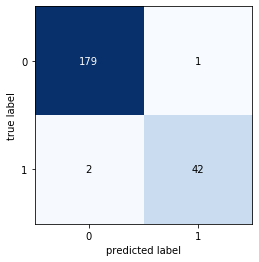

In [59]:
# dividing X, y into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

model = GradientBoostingClassifier(n_estimators=50, max_depth=6, random_state=0).fit(X_train, y_train)
y_pred = model.predict(X_test)

# Calculate accuracy
acc = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

results = confusion_matrix(y_test, y_pred)
print ("Confusion Matrix Gradient Boosting:")
print (results)
plot_confusion_matrix(results)

<font size="4"><font color='Blue'>**Sample Submission CSV**</font>

In [60]:
# Get the sample submission csv based on the Test Data
prediction=np.where(model.predict(clicklog_test.drop(['record_id'],1))==1,"TRUE","FALSE")

submission_columbia=pd.DataFrame(list(zip(clicklog_test['record_id'],list(prediction))),
                       columns=['Record ID','Fraud Conversion'])
submission_columbia.to_csv('sample_submission.csv',index=False)

In [61]:
#Show the records where the actual did not match the predicted
df_grad = pd.DataFrame({'Actual Condition': y_test, 'Predicted Condition': y_pred, 'Diff': y_test - y_pred})
df_grad[df_grad.Diff != 0]

,Actual Condition,Predicted Condition,Diff
142,1,0,1
141,1,0,1
350,0,1,-1


<font size="4"><font color='Blue'>**Print ACCURACY**</font>

In [62]:
print ('Accuracy: ', round(acc, 2)*100)

Accuracy:  99.0
